In [7]:
!pip install torch torchvision Pillow tqdm torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from torchinfo import summary

%matplotlib inline
sns.set()

In [9]:
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3)),
    transforms.RandomAffine(degrees=0, scale=(0.5, 1)),
    transforms.RandomAffine(degrees=0, shear=(-10, 10, -10, 10)),
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081) # mean and std of mnist dataset
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1307, 0.3081)
])

In [10]:
train_dataset = torchvision.datasets.MNIST(root='./dataset', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.MNIST(root='./dataset', train=False, transform=test_transform)

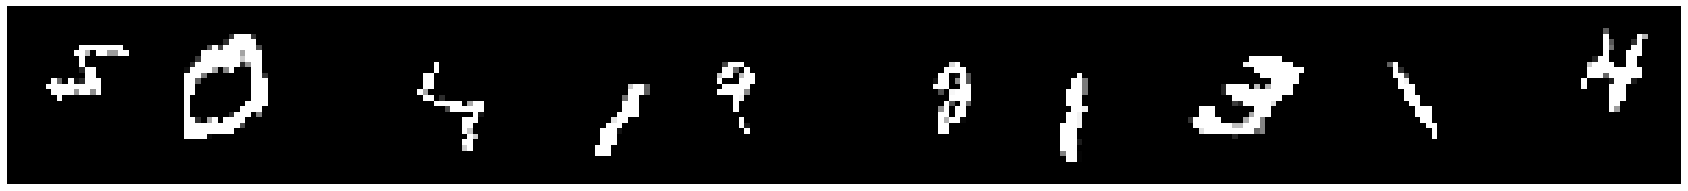

In [11]:
# Get the first 10 training examples and their labels
images, labels = zip(*[train_dataset[i] for i in range(10)])

# Convert the images to a tensor
images = torch.stack(images)

fig, ax = plt.subplots(figsize=(30, 10))

# Use make_grid to create a grid of images
grid = torchvision.utils.make_grid(images, nrow=10, )

# Convert the grid to a NumPy array and plot it
plt.imshow(grid.numpy().transpose((1, 2, 0)))

plt.axis('off')
plt.show()

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=os.cpu_count(), pin_memory=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# clear the GPUs
torch.cuda.empty_cache()

device

device(type='cuda')

In [14]:
# class CNN(nn.Module):
#   def __init__(self, classes):
#     super(CNN, self).__init__()
#     self.conv1 = nn.Sequential(
#         nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(32),
#         nn.MaxPool2d(kernel_size=(2, 2), stride=2),
#         nn.LeakyReLU(0.01)
#     )

#     self.conv2 = nn.Sequential(
#         nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
#         nn.BatchNorm2d(64),
#         nn.MaxPool2d(kernel_size=2, stride=2),
#         nn.LeakyReLU(0.01)
#     )

#     self.classifier = nn.Sequential(
#         nn.Linear(in_features=64 * 7 * 7, out_features=64),
#         nn.LeakyReLU(0.01),
#         nn.Linear(in_features=64, out_features=classes),
#     )

#   def forward(self, x):
#     x = self.conv1(x)
#     x = self.conv2(x)

#     x = torch.flatten(x, 1)

#     x = self.classifier(x)
#     return x

In [15]:
class CNN(nn.Module):
  def __init__(self, classes):
    super(CNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=16, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        nn.LeakyReLU(0.01)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=8, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.LeakyReLU(0.01)
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features=64 * 1 * 1, out_features=64),
        nn.LeakyReLU(0.01),
        nn.Linear(in_features=64, out_features=classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    x = torch.flatten(x, 1)

    x = self.classifier(x)
    return x

In [16]:
model = CNN(10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=0.001, momentum=0.3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [17]:
summary(model=model, input_size=[128, 1, 28, 28], device=device, col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"], depth=10)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Trainable
CNN                                      [128, 1, 28, 28]          [128, 10]                 --                        --                        True
├─Sequential: 1-1                        [128, 1, 28, 28]          [128, 32, 7, 7]           --                        --                        True
│    └─Conv2d: 2-1                       [128, 1, 28, 28]          [128, 32, 15, 15]         8,224                     [16, 16]                  True
│    └─BatchNorm2d: 2-2                  [128, 32, 15, 15]         [128, 32, 15, 15]         64                        --                        True
│    └─MaxPool2d: 2-3                    [128, 32, 15, 15]         [128, 32, 7, 7]           --                        [2, 2]                    --
│    └─LeakyReLU: 2-4                    [128, 32, 7, 7]           [128, 32, 7, 7]           --  

In [18]:
for epoch in tqdm(range(2)):
    model.train()

    train_acc = 0.0
    train_loss = 0.0
    train_size = len(train_loader)
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # update the weights and biases

        model.zero_grad() # backward function accumulates gradients, and we don't want to mix up the gradients between the mini-batches; we 0 them out

        train_loss += loss.item() / len(labels)
        _, prediction = torch.max(outputs.data, 1)

        train_acc += int(torch.sum(prediction == labels.data)) / len(labels)
    
    # average accuracy and loss across all mini-batches
    train_acc /= train_size
    train_loss /= train_size

    model.eval()

    test_acc = 0.0
    test_size = len(test_loader)

    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)

            test_acc += int(torch.sum(prediction == labels.data)) / len(labels)

        test_acc /= test_size

    print('Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Acc: {:.4f}'.format(epoch + 1, train_loss, train_acc, test_acc))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.0186, Train Acc: 0.5927, Test Acc: 0.9154
Epoch: 2, Train Loss: 0.0106, Train Acc: 0.7737, Test Acc: 0.9355


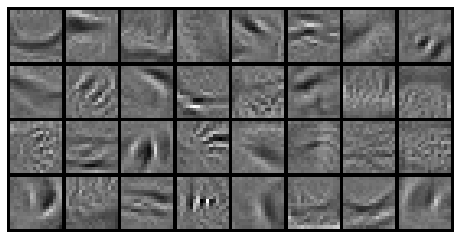

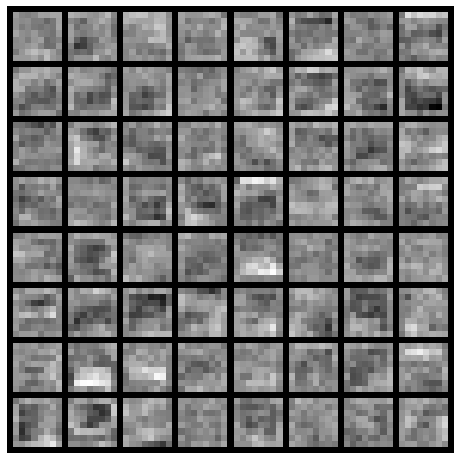

In [21]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='magma')

    plt.axis('off')
    plt.ioff()
    plt.show()


if __name__ == "__main__":
    filter = model.conv1[0].weight.data.clone()
    visTensor(filter, ch=0, allkernels=False)

    filter = model.conv2[0].weight.data.clone()
    visTensor(filter, ch=0, allkernels=False)